In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import logging 
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from kernel_wasserstein_flows.gradient_flow import gradient_flow
from kernel_wasserstein_flows.kernels import gaussian_kernel
from kernel_wasserstein_flows.config import LOG_LEVELS
LOG_LEVELS['gradient_flow'] = logging.INFO

In [4]:
def _generate_data():
    N, r, _delta = 80, 0.3, 0.5
    
    X = np.c_[r * np.cos(np.linspace(0, 2 * np.pi, N + 1)), r * np.sin(np.linspace(0, 2 * np.pi, N + 1))][:-1]  # noqa
    for i in [1, 2]:
        X = np.r_[X, X[:N, :]-i*np.array([0, (2 + _delta) * r])]

    rs = np.random.RandomState(42)
    Y = rs.randn(N*(2+1), 2) / 100 - np.array([r/np.sqrt(2), r/np.sqrt(2)])
    Y = rs.randn(N*(2+1), 2) / 100 - np.array([0, r])

    Y = torch.from_numpy(Y).float()
    X = torch.from_numpy(X).float()
    Y.requires_grad = True
    return X, Y

In [5]:
from kernel_wasserstein_flows.kale import kale_penalized, kale_penalized_first_variation
def _gen():
    return X, Y

_gf_default_kwargs = dict(
    max_iter=50000,
    random_seed=20,
    noise_level_callback=lambda x: 1e-10,
    num_noisy_averages=1,
    generator=_gen,
    generator_kwargs=dict(),
    kernel=gaussian_kernel,
    kernel_kwargs={'sigma': 0.1},
    loss=kale_penalized,
    loss_first_variation=kale_penalized_first_variation
)

_kale_default_kwargs = {
    "inner_max_iter": 800,
    "inner_tol": 1e-6,
    "inner_a": 0.4,
    "inner_b": 0.8,
    "inplace": False,
    "input_check":True,
    "dual_gap_tol": 1e-2,
    "optimization_method":"newton",
}

In [6]:
results = {}

In [7]:
import time 
import numpy as np
import torch

for _lambda_, lr, exp_name in zip([0.001, 10000], [0.0001, 0.001], ['kale_0001', 'kale_10000']):
    t0 = time.time()
    X, Y = _generate_data()
    args, (X, Y), (trajectories, records, loss_states) = gradient_flow(lr=lr, loss_kwargs={**_kale_default_kwargs, 'lambda_': _lambda_}, **_gf_default_kwargs)
    print(f'total time {time.time() - t0:.3f}s')
    results[exp_name] = { 
        'args': args,
        'X': X,
        'Y': Y,
        'trajectories': trajectories,
        'records': records,
        'loss_states': loss_states
    }

 gradient_flow: X.requires_grad: False, Y.requires_grad: True
 gradient_flow: loss: 3.66e+00 grad_norm: 1.98e+02
 gradient_flow: loss: 1.04e-01 grad_norm: 8.34e+00
 gradient_flow: loss: 2.83e-02 grad_norm: 3.92e+00
 gradient_flow: loss: 8.86e-03 grad_norm: 2.10e+00
 gradient_flow: loss: 3.02e-03 grad_norm: 1.07e+00
 gradient_flow: loss: 1.23e-03 grad_norm: 8.15e-01
 gradient_flow: loss: 5.23e-04 grad_norm: 3.88e-01
 gradient_flow: loss: 2.70e-04 grad_norm: 2.57e-01
 gradient_flow: loss: 1.32e-04 grad_norm: 1.36e-01
 gradient_flow: loss: 3.45e-05 grad_norm: 5.17e-02
 gradient_flow: X.requires_grad: False, Y.requires_grad: True
 gradient_flow: loss: 3.87e-01 grad_norm: 4.16e+00


total time 512.821s


 gradient_flow: loss: 6.33e-03 grad_norm: 6.58e-01
 gradient_flow: loss: 1.94e-03 grad_norm: 3.08e-01
 gradient_flow: loss: 7.94e-04 grad_norm: 1.70e-01
 gradient_flow: loss: 4.30e-04 grad_norm: 9.88e-02
 gradient_flow: loss: 2.97e-04 grad_norm: 6.36e-02
 gradient_flow: loss: 2.36e-04 grad_norm: 4.55e-02
 gradient_flow: loss: 2.02e-04 grad_norm: 3.64e-02
 gradient_flow: loss: 1.80e-04 grad_norm: 2.84e-02
 gradient_flow: loss: 1.67e-04 grad_norm: 2.12e-02


total time 490.888s


In [8]:
# uncomment lines below in this cell to view an interactive visualisation of the computed flows
# from kernel_wasserstein_flows.plotting import vizualize_results
# %matplotlib ipympl
# 
# exp_name = 'kale_0001'
# if args['generator_kwargs'].get('d') == 2:
#     vs = compute_velocity_field(
#         X, trajectories,
#         results[exp_name]['args']['kernel'], results[exp_name]['args']['kernel_kwargs'], results[exp_name]['args']['loss'], results[exp_name]['args']['loss_kwargs'],
#         results[exp_name]['args']['loss_first_variation'], results[exp_name]['loss_states']
#     )
# else:
#     vs = None
# vizualize_results(results[exp_name]['X'], results[exp_name]['Y'], results[exp_name]['trajectories'], pd.json_normalize(results[exp_name]['records']), "MMD", metrics_subset=['loss'],
#                   velocities=vs)

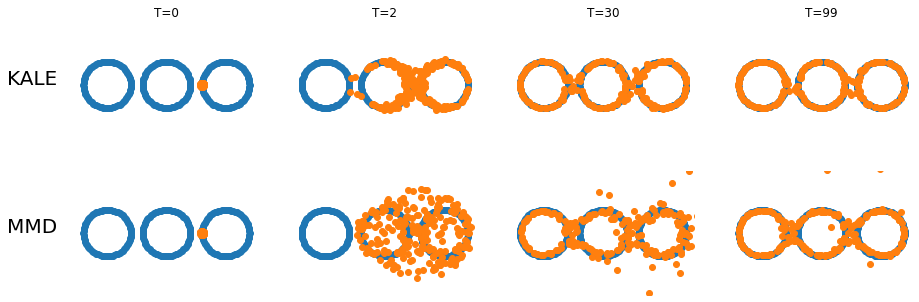

In [9]:
f, axs = plt.subplots(nrows=2, ncols=4, figsize=(15, 5))
    
iters = [0, 2, 30, 99]
for axs_row, div, pretty_name in zip(axs, ("kale_0001", "kale_10000"), ('KALE', 'MMD')):
    axs_row[0].text(-0.1, 0.5, pretty_name, size=20, transform=axs_row[0].transAxes, horizontalalignment='right')
    for ax, iter_no in zip(axs_row, iters):
        if pretty_name == "KALE":
            ax.set_title(f'T={iter_no}')
            
        ax.set_xlim([-1.9, 0.4])
        ax.set_ylim([-0.8, 0.8])
        ax.scatter(results[div]['X'][:, 1], results[div]['X'][:, 0])
        ax.scatter(results[div]['trajectories'][iter_no, :, 1], results[div]['trajectories'][iter_no, :, 0])
        ax.axis('off')

In [10]:
# uncomment lines below in this cell to view an animation of the computed flows

# import os
# import numpy as np
# from mpl_toolkits.mplot3d import Axes3D
# import matplotlib.pyplot as plt
# from matplotlib.animation import FuncAnimation
# import matplotlib.animation as animation
# from IPython.display import HTML
# 
# %matplotlib ipympl
# 
# def _has_ffmpeg():
#     # XXX: only works on unix
#     return os.system("which ffmpeg") == 0
# 
# SHOW_ANIMATION=True
# exp_name = 'kale_0001'
# 
# if _has_ffmpeg() and SHOW_ANIMATION:
#     def update(frame):
#         _animate_scatter.set_offsets(results[exp_name]['trajectories'][frame][:, ::-1])
#         return (_animate_scatter,)
# 
#     # create initial plot
#     animate_fig, animate_ax = plt.subplots()
#     animate_fig.patch.set_alpha(0.)
#     plt.axis('off')
#     # animate_ax.scatter(Ys[:, 0], Ys[:, 1])
#     animate_ax.set_xlim(-2, 1)
#     animate_ax.set_ylim(-1, 1)
#     
#     # awkard way to share state for now
#     animate_ax.scatter(results[exp_name]['X'][:, 1], results[exp_name]['X'][:, 0])
#     _animate_scatter = animate_ax.scatter(results[exp_name]['trajectories'][0][:, 1], results[exp_name]['trajectories'][0][:, 0])
# 
#     ani_kale = FuncAnimation(
#         animate_fig,
#         update,
#         frames=list(range(0, 100)),
#         # init_func=init,
#         # blit=True,
#         interval=20,
#     )
#     HTML(ani_kale.to_html5_video())